In [2]:
import pandas as pd
import datetime
from geopy import distance
import numpy as np
from collections import defaultdict
import progressbar
import operator
import secrets
import random
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
df = pd.read_pickle('prepared_telco_data.pickle')


In [3]:
df_200 = df.sample(n=200)
df_200 = df_200.reset_index()

In [4]:
class Species():
    frontier = 0
    distance = 0 
    servers = []
    solution = []
    accessDelay = 0
    workloadBalance = 0
    id = 0 
    fitness = 0
    def __init__(self,f,d,s,sol,wB,aD, id):
        self.frontier = f
        self.distance = d 
        self.servers = s
        self.solution = sol
        self.accessDelay = aD
        self.workloadBalance = wB
        self.id = id
    def __repr__(self):
        return "Species: " + str(self.id) + " Frontier: " + str(self.frontier) + " distance: " + str(self.distance) + " Access Delay: " + str(self.accessDelay) + " Workload Balance: " + str(self.workloadBalance) + " Servers: " + str(len(self.servers))

In [5]:
def accessDelay(solution, data):
    delay = 0
    i = 0
    for location in solution:
        delay += distance.distance(data.iloc[location]['location'],data.iloc[i]['location']).km
        i+=1
    return delay
def workloadBalance(solution, data):
    servers = dict.fromkeys(solution,0)
    for index,row in data.iterrows():
        servers[solution[index]] +=  row['workload']
    total = 0
    mean = sum(servers.keys())/len(servers)
    for key,value in servers.items():
        total += (value - mean)**2
    return np.sqrt(total/len(servers))
def checkDominance(a,b, check_servers = False):
    if check_servers:
        if a.accessDelay < b.accessDelay and a.workloadBalance <= b.workloadBalance and len(a.servers) <= len(b.servers):
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance < b.workloadBalance and len(a.servers) <= len(b.servers):
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance <= b.workloadBalance and len(a.servers) < len(b.servers):
            return True
    else:
        if a.accessDelay < b.accessDelay and a.workloadBalance <= b.workloadBalance:
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance < b.workloadBalance:
            return True
    return False

In [6]:
def naive_solution(data,servers):
    solution = []
    for j in range(0,len(data)):
        best_server = 0
        min_dist = np.inf
        for server in servers:
            dist = distance.distance(data.iloc[j]['location'],data.iloc[server]['location']).km
            if dist < min_dist:
                best_server = server
                min_dist = dist
        solution.append(best_server)
    return solution
def init_pop(data, server_count = 20, pop_size = 100, server_variance = 5):
    pop = {}
    for i in progressbar.progressbar(range(pop_size)):
        if server_variance:
            server_n = np.random.randint(server_count-server_variance, server_count + server_variance)
        else:
            server_n = server_count
        servers = list(np.random.choice(range(len(data)),server_n,False))
        solution = naive_solution(data,servers)
        pop[i] = Species(0,0,servers,solution, workloadBalance(solution,data), accessDelay(solution,data),"Gen 1, Species:" + str(i))
    return pop



In [7]:
def nonDominatedSort(population, check_servers = False):
    S = {}
    n = {}
    F = defaultdict(list)
    for key in population.keys():
        S[key] = []
        n[key] = 0
        for key2 in population.keys():
            if key == key2:
                pass
            elif checkDominance(population[key],population[key2], check_servers):
                S[key].append(key2)
            elif checkDominance(population[key2],population[key], check_servers):
                n[key] += 1
        if n[key] == 0:
            population[key].frontier = 0  #set rank of species internally 
            F[0].append(key)
    i = 0
    while F[i] != []:
        Q = []
        for p in F[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    population[q].frontier = i + 1 #set rank of species internally 
                    Q.append(q)
        i = i + 1
        if not Q:
            break
        F[i] = Q
    return F

In [8]:
def crowdingDistance(population, check_servers = False):
    #set distances to 0 
    for member in population:
        member.distance = 0

    #sort by access delay and compute distances
    population = sorted(population, key = lambda x: x.accessDelay)
    population[0].distance = -np.inf
    population[-1].distance = -np.inf
    for i in range(1,len(population)-1):
        population[i].distance = population[i].distance - (population[i+1].accessDelay - population[i-1].accessDelay)/(population[-1].accessDelay - population[0].accessDelay)
    
    #sort by workload balance and compute distances
    population = sorted(population, key = lambda x: x.workloadBalance)
    population[0].distance = -np.inf
    population[-1].distance = -np.inf
    for i in range(1,len(population)-1):
        population[i].distance = population[i].distance - (population[i+1].workloadBalance - population[i-1].workloadBalance)/(population[-1].workloadBalance - population[0].workloadBalance)
    
    if check_servers:
        #sort by num servers and compute distances
        population = sorted(population, key = lambda x: len(x.servers))
        population[0].distance = -np.inf
        population[-1].distance = -np.inf
        for i in range(1,len(population)-1):
            population[i].distance = population[i].distance - (len(population[i+1].servers) - len(population[i-1].servers))/(len(population[-1].servers) - len(population[0].servers))


In [9]:
def roulette(choices):
    choice_odds = [] 
    #get odds for each choice
    for i in range(len(choices)):
        choice_odds.append((2*(len(choices) - i))/(len(choices)*(len(choices)+1)))

    #pick a choice
    max = sum([x for x in choice_odds])
    pick = np.random.uniform(0, max)
    current = 0
    selected_choice = 0
    for x in choice_odds:
        current += x
        if current >= pick:
            break
        selected_choice += 1
    return selected_choice
def selection(population, frontiers):
    #pick a frontier
    selected_frontier = roulette(frontiers)
    #get distances for each member of frontier
    distances = []
    for i in frontiers[selected_frontier]:
        distances.append((population[i].distance,i))
    distances = sorted(distances)

    #pick a specific member
    selection = roulette(distances)
    try:
        selected_member = distances[selection]
    except Exception:
        print(selection)
        print(distances)
    selected_member = selected_member[1]
    return population[selected_member]


In [10]:

def mutate(data, species, fixed_servers):
    #to start available mutations will be one server is randomly changed
    if fixed_servers:
        server = np.random.choice(species.servers)
        new_server = np.random.randint(0,len(species.solution))
        species.servers = list(species.servers)
        species.servers.append(new_server)
        species.servers.remove(server)
        species.solution = naive_solution(data,species.servers)
        species.accessDelay = accessDelay(species.solution,data)
        species.workloadBalance = workloadBalance(species.solution, data) 

def breed(data,a,b,gen,id,fixed_servers):
    if fixed_servers:
        server_count = len(a.servers)
        new_servers = set(a.servers) | set(b.servers)
        try:
            new_servers = np.random.choice(list(new_servers), server_count, False)
        except Exception:
            print(a.servers)
            print(b.servers)
            print(new_servers)
        new_solution = []
        set_new_servers = set(new_servers)
        for i in range(len(a.solution)):
            if a.solution[i] in set_new_servers:
                new_solution.append(a.solution[i])
            elif b.solution[i] in set_new_servers:
                new_solution.append(b.solution[i])
            else:
                best_server = 0
                min_dist = np.inf
                for server in new_servers:
                    dist = distance.distance(data.iloc[i]['location'],data.iloc[server]['location']).km
                    if dist < min_dist:
                        best_server = server
                        min_dist = dist
                new_solution.append(best_server)
        return Species(0,0,new_servers,new_solution, workloadBalance(new_solution,data), accessDelay(new_solution,data), "Gen " + str(gen) + ", Species:" + str(id))

def new_generation(data,population,gen, mutation_rate, fixed_servers):       
    pop_list = sorted(population.values(), key = operator.attrgetter("frontier", "distance"))
    next_gen = {}
    i = 1
    frontiers = nonDominatedSort(population)
    for i in tqdm_notebook(range(len(population)),leave=False, desc='Next Generation'): 
        a = selection(population,frontiers)
        b = selection(population,frontiers)
        new_species = breed(data,a,b,gen,i,fixed_servers)
        n = np.random.random(1)[0]
        if n < mutation_rate:
            mutate(data, new_species, fixed_servers)
        next_gen[new_species.id] = new_species
    return next_gen

In [11]:
access_delay_averages = []
workload_balance_averages = []
access_delay_mins = []
workload_balance_mins = []
def evolution(data,generations = 20, pop_size = 150, server_count = 20, fixed_servers = True):
    population = init_pop(df_200,pop_size=pop_size, server_count =server_count,server_variance = 0)
    for i in tqdm_notebook(range(generations), desc='Generation'):
        gen = {}
        frontiers = nonDominatedSort(population)
        crowdingDistance(list(population.values()))
        pop_list = sorted(population.values(), key = operator.attrgetter("frontier", "distance"))
        population = {}
        for k in range(0,pop_size):
            id = pop_list[k].id
            population[id] = pop_list[k]

        if i%1 == 0:
            print("Generation: " + str(i))
            ads = []
            wbs = []
            for key,value in population.items():
                ads.append(value.accessDelay)
                wbs.append(value.workloadBalance)
            plt.xlabel("Access Delay")
            plt.ylabel("Workload Balance")
            plt.scatter(ads,wbs)
            plt.show()
            average_ad = sum(ads)/len(ads)
            average_wb = sum(wbs)/len(wbs)
            access_delay_averages.append(average_ad)
            workload_balance_averages.append(average_wb)
            access_delay_mins.append(min(ads))
            workload_balance_mins.append(min(wbs))
            print("Average Access Delay:" + str(average_ad))
            print("Average Workload Balance:" + str(average_wb))
            print("Minimum Access Delay:" + str(min(ads)))
            print("Minimum Workload Balance:" + str(min(wbs)))

        
        next_gen = new_generation(data,population, i+1, .1, fixed_servers)
        population.update(next_gen)
    gen = {}
    frontiers = nonDominatedSort(population)
    j = 0
    while len(gen) < pop_size:
        front = [population[x] for x in frontiers[j]]
        crowdingDistance(front)
        gen.update({key: value for key, value in population.items() if key in frontiers[j]})
        j += 1
    population = gen
    return frontiers,population
   
        

100% (150 of 150) |######################| Elapsed Time: 0:05:46 Time:  0:05:46


Generation: 0


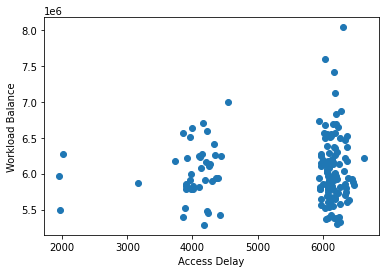

Average Access Delay:5555.114421010435
Average Workload Balance:6038830.938601884
Minimum Access Delay:1956.3563920560528
Minimum Workload Balance:5287497.137409249


Generation: 1


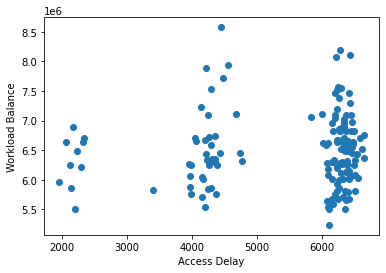

Average Access Delay:5512.913119481904
Average Workload Balance:6492501.737518437
Minimum Access Delay:1956.3563920560528
Minimum Workload Balance:5236336.989334864


Generation: 2


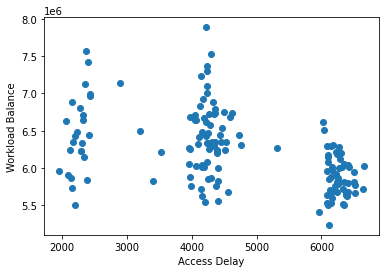

Average Access Delay:4641.377943806014
Average Workload Balance:6223712.842659792
Minimum Access Delay:1956.3563920560528
Minimum Workload Balance:5236336.989334864


Generation: 3


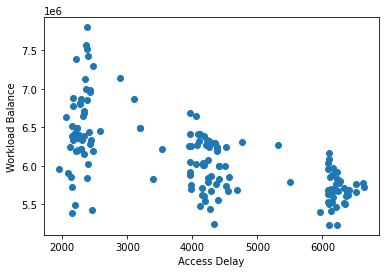

Average Access Delay:4096.274179605338
Average Workload Balance:6112430.014001631
Minimum Access Delay:1956.3563920560528
Minimum Workload Balance:5234433.027733992


Generation: 4


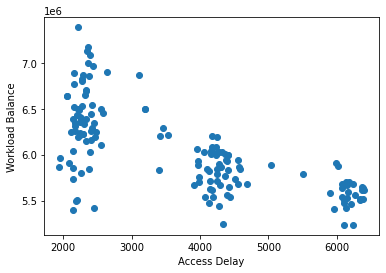

Average Access Delay:3746.686210986746
Average Workload Balance:6034424.133032295
Minimum Access Delay:1946.165352193182
Minimum Workload Balance:5234433.027733992


Generation: 5


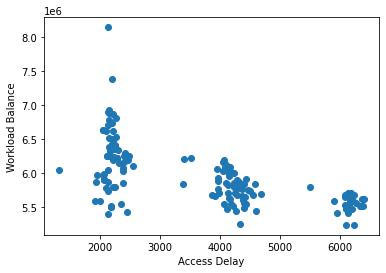

Average Access Delay:3655.5629158120323
Average Workload Balance:5951839.210700848
Minimum Access Delay:1332.2489216620315
Minimum Workload Balance:5234433.027733992


Generation: 6


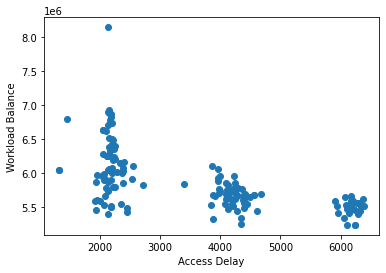

Average Access Delay:3613.862361410208
Average Workload Balance:5855015.692555999
Minimum Access Delay:1332.2489216620315
Minimum Workload Balance:5234433.027733992


Generation: 7


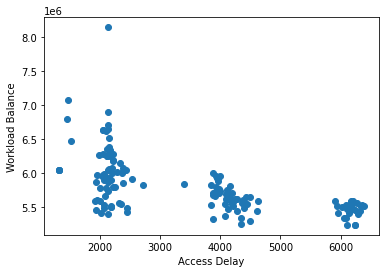

Average Access Delay:3512.557444552399
Average Workload Balance:5803240.513821003
Minimum Access Delay:1332.2489216620315
Minimum Workload Balance:5234433.027733992


Generation: 8


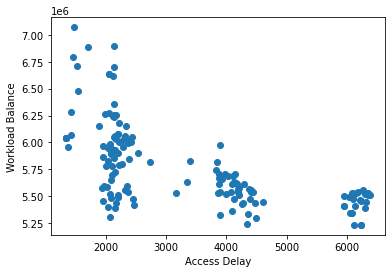

Average Access Delay:3328.558207430836
Average Workload Balance:5775253.951144751
Minimum Access Delay:1332.2489216620315
Minimum Workload Balance:5234433.027733992


Generation: 9


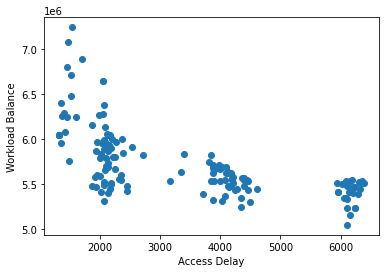

Average Access Delay:3392.864792719327
Average Workload Balance:5722586.033836405
Minimum Access Delay:1332.2489216620315
Minimum Workload Balance:5043098.141188143


Generation: 10


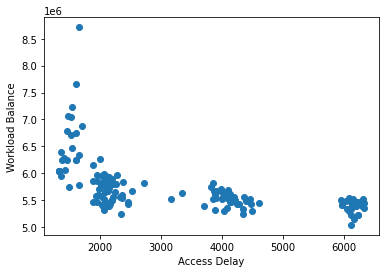

Average Access Delay:3297.445196675371
Average Workload Balance:5733094.4071971215
Minimum Access Delay:1332.2489216620315
Minimum Workload Balance:5043098.141188143


Generation: 11


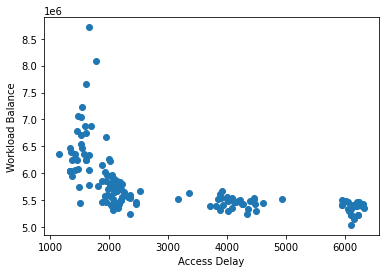

Average Access Delay:3021.4010646510947
Average Workload Balance:5782599.031707149
Minimum Access Delay:1154.8090129889417
Minimum Workload Balance:5043098.141188143


Generation: 12


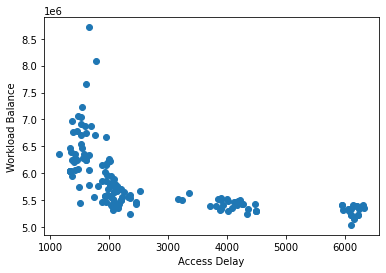

Average Access Delay:2822.0784335351527
Average Workload Balance:5824390.646302153
Minimum Access Delay:1154.8090129889417
Minimum Workload Balance:5043098.141188143


Generation: 13


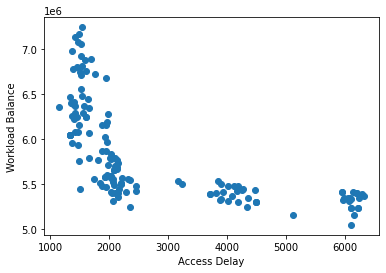

Average Access Delay:2783.7154332872656
Average Workload Balance:5808794.8176863
Minimum Access Delay:1154.8090129889417
Minimum Workload Balance:5043098.141188143


Generation: 14


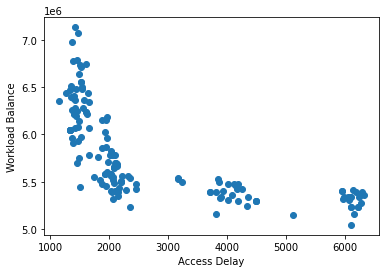

Average Access Delay:2749.495115777033
Average Workload Balance:5775197.67321983
Minimum Access Delay:1154.8090129889417
Minimum Workload Balance:5043098.141188143


Generation: 15


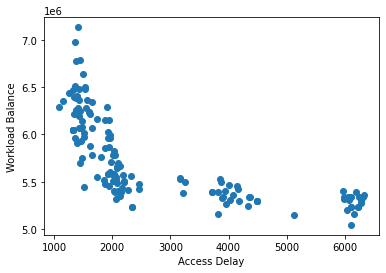

Average Access Delay:2736.311142973856
Average Workload Balance:5745549.444416916
Minimum Access Delay:1093.8038971286655
Minimum Workload Balance:5043098.141188143


Generation: 16


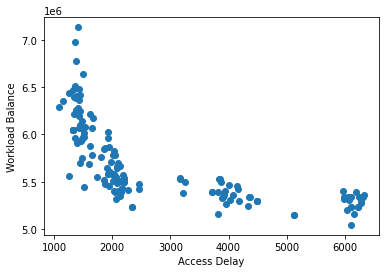

Average Access Delay:2781.0952743448756
Average Workload Balance:5698959.555365701
Minimum Access Delay:1093.8038971286655
Minimum Workload Balance:5043098.141188143


Generation: 17


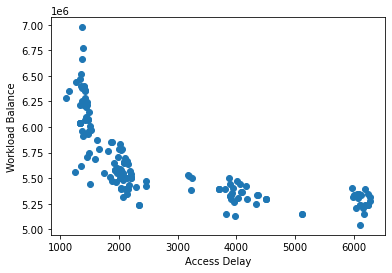

Average Access Delay:2841.126017626158
Average Workload Balance:5653162.251873724
Minimum Access Delay:1093.8038971286655
Minimum Workload Balance:5043098.141188143


Generation: 18


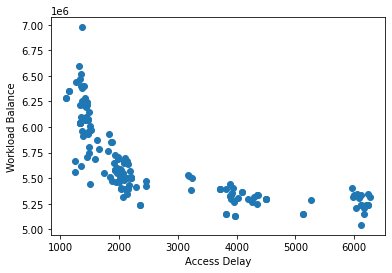

Average Access Delay:2765.8604639038836
Average Workload Balance:5641546.971821349
Minimum Access Delay:1093.8038971286655
Minimum Workload Balance:5043098.141188143


Generation: 19


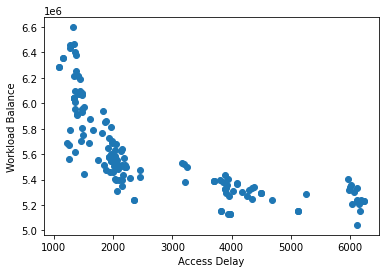

Average Access Delay:2794.9964029640564
Average Workload Balance:5601299.341594641
Minimum Access Delay:1093.8038971286655
Minimum Workload Balance:5043098.141188143


In [12]:
frontiers,population = evolution(df_200,pop_size=150)

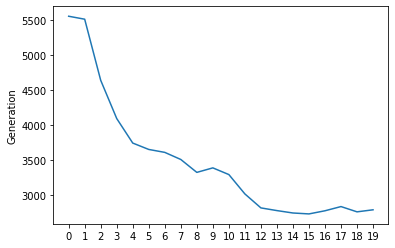

In [19]:
plt.ylabel("Access Delay Average")
plt.ylabel("Generation")
plt.xticks(range(0,20))
plt.plot(access_delay_averages)

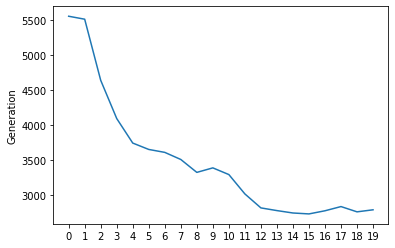

In [20]:
plt.ylabel("Workload Balance Average")
plt.ylabel("Generation")
plt.xticks(range(0,20))
plt.plot(access_delay_averages)

In [15]:
df_200.to_pickle("200accesspointdata.pickle")

In [22]:
frontiers[0]

['Gen 9, Species:5',
 'Gen 15, Species:148',
 'Gen 17, Species:38',
 'Gen 14, Species:137',
 'Gen 19, Species:23',
 'Gen 18, Species:63',
 'Gen 19, Species:14',
 'Gen 15, Species:128',
 'Gen 16, Species:98',
 'Gen 11, Species:58',
 'Gen 10, Species:21',
 'Gen 19, Species:137',
 'Gen 8, Species:37',
 'Gen 10, Species:2',
 'Gen 7, Species:113',
 'Gen 18, Species:53',
 'Gen 18, Species:88',
 'Gen 20, Species:83']

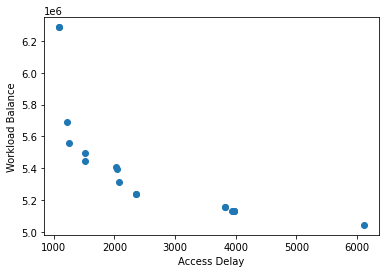

Average Access Delay:2673.3555079480607
Average Workload Balance:5401087.701414602
Minimum Access Delay:1093.8038971286655
Minimum Workload Balance:5043098.141188143


In [24]:
frontiers = nonDominatedSort(population)
front1 = {key:value for key,value in population.items() if value.id in frontiers[0]}
ads = []
wbs = []
for key,value in front1.items():
    ads.append(value.accessDelay)
    wbs.append(value.workloadBalance)
plt.xlabel("Access Delay")
plt.ylabel("Workload Balance")
plt.scatter(ads,wbs)
plt.show()
average_ad = sum(ads)/len(ads)
average_wb = sum(wbs)/len(wbs)
access_delay_averages.append(average_ad)
workload_balance_averages.append(average_wb)
access_delay_mins.append(min(ads))
workload_balance_mins.append(min(wbs))
print("Average Access Delay:" + str(average_ad))
print("Average Workload Balance:" + str(average_wb))
print("Minimum Access Delay:" + str(min(ads)))
print("Minimum Workload Balance:" + str(min(wbs)))

In [25]:
import pickle

In [36]:
file = open("results.pickle","wb")
pickle.dump(population, file)

In [ ]:
file = open("results.pickle","r")
population = pickle.loads(file)